100%|██████████| 26421880/26421880 [00:02<00:00, 12078460.50it/s]


Extracting /data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 174473.99it/s]


Extracting /data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:02<00:00, 1779573.47it/s]


Extracting /data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 22306071.27it/s]


Extracting /data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /data/FashionMNIST/raw

Epoch [1/10], Loss: 0.4967
Epoch [2/10], Loss: 0.7183
Epoch [3/10], Loss: 0.4502
Epoch [4/10], Loss: 0.5941
Epoch [5/10], Loss: 0.6012
Epoch [6/10], Loss: 0.2557
Epoch [7/10], Loss: 0.2748
Epoch [8/10], Loss: 0.3117
Epoch [9/10], Loss: 0.4048
Epoch [10/10], Loss: 0.2664
Accuracy of the model on the test images: 87.92%


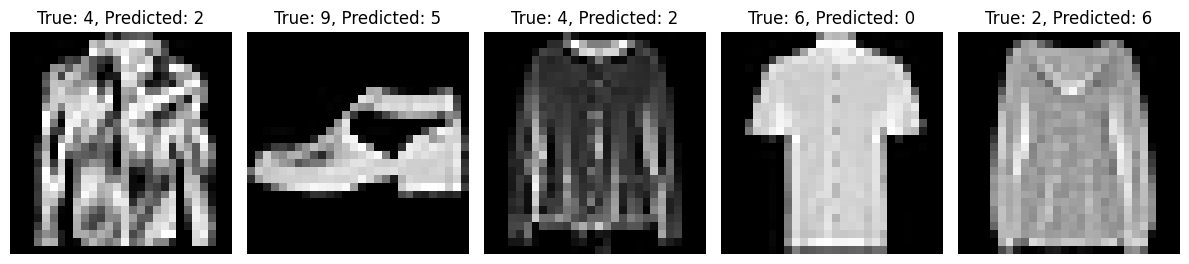

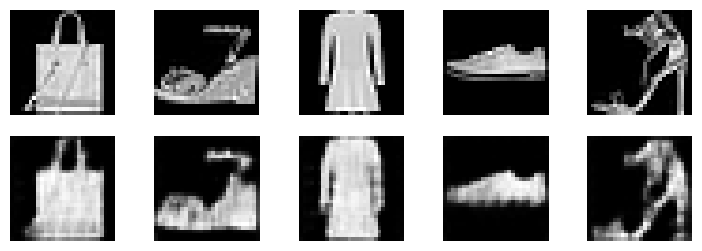

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalizace mezi -1 a 1
])

train_dataset = FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

class AutoencoderWithClassification(nn.Module):
    def __init__(self):
        super(AutoencoderWithClassification, self).__init__()
        self.encoder = nn.Sequential(
            # 1x28x28
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),  # Výstup: 16x14x14
            nn.ReLU(),
            nn.Conv2d(16, 4, kernel_size=3, stride=2, padding=1),  # Výstup: 4x7x7
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(4, 16, kernel_size=4, stride=2, padding=1),  # Výstup: 16x14x14
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=4, stride=2, padding=1),  # Výstup: 1x28x28
            nn.Tanh()  # Tanh, protože jsme normalizovali data na [-1, 1]
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),  # Převod 3D tensoru na 1D
            nn.Linear(4 * 7 * 7, 128),  # Skrytá vrstva
            nn.ReLU(),
            nn.Linear(128, 10)  # Výstupní vrstva pro 10 tříd (Fashion-MNIST)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        classified = self.classifier(encoded.view(encoded.size(0), -1))
        return decoded, classified

# Inicializace modelu
model = AutoencoderWithClassification()

# Kontrola, zda je k dispozici GPU a přesun modelu na GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# 3. Definice ztrátové funkce a optimalizátoru
criterion_reconstruction = nn.MSELoss()  # Střední kvadratická chyba pro rekonstrukci
criterion_classification = nn.CrossEntropyLoss()  # Křížová entropie pro klasifikaci
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 4. Trénink modelu
num_epochs = 10

for epoch in range(num_epochs):
    for data in train_loader:
        img, labels = data  # Načtení obrázků a odpovídajících labelů

        # Přesun dat na GPU
        img = img.to(device)
        labels = labels.to(device)

        model.train()  # Přepneme model do tréninkového režimu

        optimizer.zero_grad()  # Nula gradienů

        output_reconstruction, output_classification = model(img)  # Forward pass
        loss_reconstruction = criterion_reconstruction(output_reconstruction, img)  # Rekonstrukční ztráta
        loss_classification = criterion_classification(output_classification, labels)  # Klasifikační ztráta

        loss = loss_reconstruction + loss_classification  # Celková ztráta
        loss.backward()  # Backward pass
        optimizer.step()  # Optimalizace

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# 5. Testování modelu s vizualizací špatně klasifikovaných obrázků
def test_model_and_show_misclassified(model, test_loader):
    model.eval()  # Přepneme model do evaluačního režimu
    correct = 0
    total = 0
    misclassified_images = []  # Seznam pro špatně klasifikované obrázky
    misclassified_labels = []   # Seznam pro správné labely
    misclassified_preds = []    # Seznam pro predikované labely

    with torch.no_grad():
        for data in test_loader:
            img, labels = data

            # Přesun dat na GPU
            img = img.to(device)
            labels = labels.to(device)

            output_reconstruction, output_classification = model(img)
            _, predicted = torch.max(output_classification.data, 1)  # Predikce třídy
            total += labels.size(0)  # Celkový počet vzorků
            correct += (predicted == labels).sum().item()  # Počet správných predikcí

            # Uložení špatně klasifikovaných obrázků
            for i in range(len(labels)):
                if predicted[i] != labels[i]:
                    misclassified_images.append(img[i].cpu())  # Převod na CPU pro vizualizaci
                    misclassified_labels.append(labels[i].cpu().item())  # Správný label
                    misclassified_preds.append(predicted[i].cpu().item())  # Predikovaný label

    accuracy = 100 * correct / total
    print(f'Accuracy of the model on the test images: {accuracy:.2f}%')

    # Zobrazení špatně klasifikovaných obrázků
    show_misclassified_images(misclassified_images, misclassified_labels, misclassified_preds)

def show_misclassified_images(images, true_labels, predicted_labels, num_images=5):
    plt.figure(figsize=(12, 6))
    for i in range(num_images):
        plt.subplot(2, num_images, i + 1)
        plt.imshow(images[i][0], cmap='gray')
        plt.title(f'True: {true_labels[i]}, Predicted: {predicted_labels[i]}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Testování s vizualizací špatně klasifikovaných obrázků
test_model_and_show_misclassified(model, test_loader)

# 6. Vizualizace rekonstruovaných obrázků
def visualize_reconstruction(model, data_loader):
    model.eval()  # Přepneme model do evaluačního režimu
    with torch.no_grad():
        for data in data_loader:
            img, _ = data

            # Přesun dat na GPU
            img = img.to(device)

            reconstructed, _ = model(img)

            # Zobrazení původních a rekonstruovaných obrázků
            plt.figure(figsize=(9, 3))
            for i in range(5):
                # Původní obrázky
                ax = plt.subplot(2, 5, i + 1)
                plt.imshow(img[i][0].cpu(), cmap='gray')
                plt.axis('off')

                # Rekonstruované obrázky
                ax = plt.subplot(2, 5, i + 6)
                plt.imshow(reconstructed[i][0].cpu(), cmap='gray')
                plt.axis('off')

            plt.show()
            break  # Zobrazíme pouze první batch

# Vizualizace
visualize_reconstruction(model, train_loader)
